데이터 출처 : https://www.kaggle.com/c/ga-customer-revenue-prediction

참고 커널
- https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue
- https://www.kaggle.com/erikbruin/google-analytics-eda-lightgbm-screenshots

In [1]:
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

train 데이터의 다중 값 필드가 있어 데이터를 불러올 때 단일 값 필드로 변경합니다.

In [2]:
import os

In [3]:
def load_df(csv_path='train_1.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

- 데이터 불러옵니다

In [4]:
df = load_df()

Loaded train_1.csv. Shape: (87985, 55)


In [5]:
df.shape

(87985, 55)

- 데이터의 칼럼을 확인합니다.

In [6]:
df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.t

데모버전으로 확인할 수 없는 값을 NULL 값으로 대체합니다.
- 'not available in demo dataset' 널 (null)값으로 변경 

In [7]:
df

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1.13166E+18,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,3.77306E+17,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3.89555E+18,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4.76345E+18,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not avai

In [9]:
for col in df.columns:
    df[col] = df[col].apply(lambda x : np.nan if  x in remove else x)

NameError: name 'remove' is not defined

In [10]:
df.head(10)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1.13166E+18,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,3.77306E+17,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3.89555E+18,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4.76345E+18,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not avai

In [11]:
df_final.shape

NameError: name 'df_final' is not defined

결측치 비율을 보여줍니다.

In [12]:
(df.isnull().sum() / len(df)) * 100

channelGrouping                                       0.000000
date                                                  0.000000
fullVisitorId                                         0.000000
sessionId                                             0.000000
socialEngagementType                                  0.000000
visitId                                               0.000000
visitNumber                                           0.000000
visitStartTime                                        0.000000
device.browser                                        0.000000
device.browserVersion                                 0.000000
device.browserSize                                    0.000000
device.operatingSystem                                0.000000
device.operatingSystemVersion                         0.000000
device.isMobile                                       0.000000
device.mobileDeviceBranding                           0.000000
device.mobileDeviceModel                              0

결측치 비율이 전반적으로 높습니다. 타겟값 transactionRevenue 결측치 비율도 상당히 높습니다.

### 전처리

- 1차 필터

결측치 100% 기준으로 제거할 칼럼들을 뽑아서 데이터셋에서 삭제합니다.





In [13]:
df.columns[df.isnull().sum() / len(df) == 1]

Index([], dtype='object')

In [14]:
drop_col = df.columns[df.isnull().sum() / len(df) == 1]

In [15]:
df = df.drop(drop_col.values, axis = 1)

In [16]:
df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.t

In [17]:
df = df.drop(['totals.visits'], axis = 1)

- 2차 필터 

종속 변수(transactionRevenue)의 값이 NULL이 '아닌' 값만 추출합니다 
(캐글의 다른 커널에서는 transactionRevenue의 값이 null이면 0으로 대체하여 진행했습니다.)

In [18]:
df = df[df['totals.transactionRevenue'].isnull() == False]

In [19]:
df

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
752,Direct,20160902,6.19419E+18,6194193421514403509_1472843572,Not Socially Engaged,1472843572,1,1472843572,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,Michigan,Detroit MI,Ann Arbor,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,11,11,NaN,1,37860000,(not set),(direct),(none),NaN,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,Organic Search,20160902,5.32717E+18,5327166854580374902_1472844906,Not Socially Engaged,1472844906,3,1472844906,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,11,10,NaN,NaN,306670000,(not set),google,organic,(not provided),not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799,Referral,20160902,8.88505E+18,8885051388942907862_1472827393,Not Socially Engaged,1472827393,7,1472827393,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,13,11,NaN,NaN,68030000,(not set),mall.googleplex.com,referral,NaN,not available in demo dataset,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,Referral,20160902,1.85468E+17,0185467632009737931_1472846398,Not Socially Engaged,1472846398,6,1472846398,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo da

코드 실행 결과, 903653행이 11515행으로 줄었습니다. 

### 3차 결측치 처리하기

범주형 변수와 수치형 변수의 널값을 채워줘야합니다.

#### 널값 처리 전략 

- 범주형 변수는 최빈값으로 대체한다.
- 수치형 변수는 평균값으로 대체한다.



In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225 entries, 752 to 84125
Data columns (total 54 columns):
channelGrouping                                      1225 non-null object
date                                                 1225 non-null int64
fullVisitorId                                        1225 non-null object
sessionId                                            1225 non-null object
socialEngagementType                                 1225 non-null object
visitId                                              1225 non-null int64
visitNumber                                          1225 non-null int64
visitStartTime                                       1225 non-null int64
device.browser                                       1225 non-null object
device.browserVersion                                1225 non-null object
device.browserSize                                   1225 non-null object
device.operatingSystem                               1225 non-null object
device

잘못된 저장된 데이터 타입을 변환해줍니다.

In [21]:
df['totals.pageviews'] = df['totals.pageviews'].astype('int64')
df['totals.hits'] = df['totals.hits'].astype('int64')
df['totals.transactionRevenue'] = df['totals.transactionRevenue'].astype('int64')

추가로 삭제할 칼럼
- fullvisitorid와 중복되는(거의 유사한) 의미인 sessionId, visitId 삭제

In [22]:
df = df.drop(['sessionId', 'visitId'], axis = 1)

date, visitStartTime

- date 칼럼은 모두 '월'단위로 바꿔줍니다.
- visitStartTime 칼럼은  POSIX timestamp에 해당하는 지역 날짜와 시간을 반환합니다

In [23]:
df.date

752      20160902
753      20160902
799      20160902
802      20160902
859      20160902
           ...   
84080    20161129
84082    20161129
84100    20161129
84119    20161129
84125    20161129
Name: date, Length: 1225, dtype: int64

In [24]:
# library of datetime
from datetime import datetime

# This function is to extract date features
df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")

In [25]:
df["date"] = df['date'].dt.month

In [26]:
df.date

752       9
753       9
799       9
802       9
859       9
         ..
84080    11
84082    11
84100    11
84119    11
84125    11
Name: date, Length: 1225, dtype: int64

In [27]:
df['visitStartTime'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)

In [28]:
df

,channelGrouping,date,fullVisitorId,socialEngagementType,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
752,Direct,9,6.19419E+18,Not Socially Engaged,1,4,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,Michigan,Detroit MI,Ann Arbor,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,11,11,NaN,1,37860000,(not set),(direct),(none),NaN,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,Organic Search,9,5.32717E+18,Not Socially Engaged,3,4,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,11,10,NaN,NaN,306670000,(not set),google,organic,(not provided),not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799,Referral,9,8.88505E+18,Not Socially Engaged,7,23,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,13,11,NaN,NaN,68030000,(not set),mall.googleplex.com,referral,NaN,not available in demo dataset,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,Referral,9,1.85468E+17,Not Socially Engaged,6,4,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San 

fullVisitID, transactionRevenu는 따로 빼놓고, 뒤에서 다시 합치겠습니다. 
(전처리에 영향을 받지 않게 하기 위해서)

In [29]:
df_id = df[['fullVisitorId']]
df_y = df[['totals.transactionRevenue']]

df  = df.drop(['fullVisitorId', 'totals.transactionRevenue'], axis = 1)

범주형 변수 뽑습니다.

In [30]:
df.select_dtypes(exclude = ['int64']).columns.values

array(['channelGrouping', 'socialEngagementType', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent',
       'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.metro',
       'geoNetwork.city', 'geoNetwork.cityId', 'geoNetwork.networkDomain',
       'geoNetwork.latitude', 'geoNetwork.longitude',
       'geoNetwork.networkLocation', 'totals.bounces', 'totals.newVisits',
       'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.adwo

In [31]:
df_obj = df.select_dtypes(exclude = ['int64'])

수치형 변수를 뽑습니다.

In [33]:
df_num = df.select_dtypes(include = ['int64']) 

In [34]:
df_num.head()

,date,visitNumber,totals.hits,totals.pageviews
752,9,1,11,11
753,9,3,11,10
799,9,7,13,11
802,9,6,13,12
859,9,4,17,14


- 범주형 변수 널값은 확인합니다.

In [35]:
(df_obj.isnull().sum() /len(df_obj) ) * 100

channelGrouping                                        0.000000
socialEngagementType                                   0.000000
visitStartTime                                         0.000000
device.browser                                         0.000000
device.browserVersion                                  0.000000
device.browserSize                                     0.000000
device.operatingSystem                                 0.000000
device.operatingSystemVersion                          0.000000
device.isMobile                                        0.000000
device.mobileDeviceBranding                            0.000000
device.mobileDeviceModel                               0.000000
device.mobileInputSelector                             0.000000
device.mobileDeviceInfo                                0.000000
device.mobileDeviceMarketingName                       0.000000
device.flashVersion                                    0.000000
device.language                         

전체 널값인 totals.bounces, trafficSource.campaignCode 삭제합니다.

In [36]:
df_obj = df_obj.drop(['totals.bounces', 'trafficSource.campaignCode'], axis = 1)

In [37]:
from sklearn import impute

In [38]:
#범주형 널 값처리
obj_impute = impute.SimpleImputer(strategy = 'most_frequent')
impute_obj = obj_impute.fit_transform(df_obj)

#최빈값을 채운 최종 범주혀변수 데이터프레임
obj_col = df_obj.columns.values
df_obj = pd.DataFrame(impute_obj , columns= obj_col)

In [46]:
#수치형 변수 널값 평균으로 채우기 
num_impute = impute.SimpleImputer(strategy = 'mean')
impute_num = num_impute.fit_transform(df_num)

num_col = df_num.columns.values
df_num=pd.DataFrame(impute_num , columns= num_col)

### 인코딩

범주형 변수 -> 라벨 or 원핫 인코딩 (여기선 라벨인코딩으로 진행합니다) 


수치형 변수 -> 보통 표준화, 노멀라이징하는데 트리 기반의 모델을 사용함으로 따로 처리하지 않습니다.


In [51]:
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()

for col in df_obj.columns:
    df_obj[col] = lbl.fit_transform(df_obj[col])

### 최종 데이터 프레임 만들기 (아이디 + 범주형 + 수치형 + 종속변수)

In [55]:
type(df_id)
type(df_obj)
#df_num
#df_y)

pandas.core.frame.DataFrame

In [56]:
df_id = df_id.reset_index()
df_y = df_y.reset_index()

In [57]:
df_id

,index,fullVisitorId
0,752,6.19419E+18
1,753,5.32717E+18
2,799,8.88505E+18
3,802,1.85468E+17
4,859,3.24489E+18
...,...,...
1220,84080,9.01414E+18
1221,84082,8.79196E+16
1222,84100,2.89304E+18
1223,84119,2.10905E+18


In [58]:
# 옆으로 붙이기
df_final = pd.concat([df_id, df_obj, df_num, df_y], axis =1)

In [59]:
df_final.head()

,index,fullVisitorId,channelGrouping,socialEngagementType,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,date,visitNumber,totals.hits,totals.pageviews,index,totals.transactionRevenue
0,752,6.19419E+18,0,0,4,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,13,8,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,9.0,1.0,11.0,11.0,752,37860000
1,753,5.32717E+18,2,0,4,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,18,15,30,0,0,0,0,0,0,0,8,3,1,0,0,0,0,0,0,0,0,1,9.0,3.0,11.0,10.0,753,306670000
2,799,8.88505E+18,4,0,23,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,18,15,30,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,9.0,7.0,13.0,11.0,799,68030000
3,802,1.85468E+17,4,0,4,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,2,22,28,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,9.0,6.0,13.0,12.0,802,26250000
4,859,3.24489E+18,4,0,23,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,36,25,57,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,9.0,4.0,17.0,14.0,859,574150000


In [60]:
df_final.drop('index', axis =1 , inplace =True)

In [61]:
df_final.head()

,fullVisitorId,channelGrouping,socialEngagementType,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,date,visitNumber,totals.hits,totals.pageviews,totals.transactionRevenue
0,6.19419E+18,0,0,4,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,13,8,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,9.0,1.0,11.0,11.0,37860000
1,5.32717E+18,2,0,4,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,18,15,30,0,0,0,0,0,0,0,8,3,1,0,0,0,0,0,0,0,0,1,9.0,3.0,11.0,10.0,306670000
2,8.88505E+18,4,0,23,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,18,15,30,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,9.0,7.0,13.0,11.0,68030000
3,1.85468E+17,4,0,4,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,2,22,28,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,9.0,6.0,13.0,12.0,26250000
4,3.24489E+18,4,0,23,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,36,25,57,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,9.0,4.0,17.0,14.0,574150000


In [62]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 50 columns):
fullVisitorId                                        1225 non-null object
channelGrouping                                      1225 non-null int32
socialEngagementType                                 1225 non-null int32
visitStartTime                                       1225 non-null int32
device.browser                                       1225 non-null int32
device.browserVersion                                1225 non-null int32
device.browserSize                                   1225 non-null int32
device.operatingSystem                               1225 non-null int32
device.operatingSystemVersion                        1225 non-null int32
device.isMobile                                      1225 non-null int32
device.mobileDeviceBranding                          1225 non-null int32
device.mobileDeviceModel                             1225 non-null int32
device.mobileInp

In [63]:
df_final.isnull().sum()

fullVisitorId                                        0
channelGrouping                                      0
socialEngagementType                                 0
visitStartTime                                       0
device.browser                                       0
device.browserVersion                                0
device.browserSize                                   0
device.operatingSystem                               0
device.operatingSystemVersion                        0
device.isMobile                                      0
device.mobileDeviceBranding                          0
device.mobileDeviceModel                             0
device.mobileInputSelector                           0
device.mobileDeviceInfo                              0
device.mobileDeviceMarketingName                     0
device.flashVersion                                  0
device.language                                      0
device.screenColors                                  0
device.scr

In [64]:
df_final.to_csv('df_final_1.csv', index = False)

드디어 모든 준비는 끝났습니다.

### 모델링

In [65]:
df_final = pd.read_csv('df_final_1.csv')

In [66]:
df_final

,fullVisitorId,channelGrouping,socialEngagementType,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,date,visitNumber,totals.hits,totals.pageviews,totals.transactionRevenue
0,6.194190e+18,0,0,4,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,13,8,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,9.0,1.0,11.0,11.0,37860000
1,5.327170e+18,2,0,4,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,18,15,30,0,0,0,0,0,0,0,8,3,1,0,0,0,0,0,0,0,0,1,9.0,3.0,11.0,10.0,306670000
2,8.885050e+18,4,0,23,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,18,15,30,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,9.0,7.0,13.0,11.0,68030000
3,1.854680e+17,4,0,4,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,2,22,28,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,9.0,6.0,13.0,12.0,26250000
4,3.244890e+18,4,0,23,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,36,25,57,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,9.0,4.0,17.0,14.0,574150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,9.014140e+18,4,0,11,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,36,25,57,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,11.0,4.0,30.0,22.0,59980000
1221,8.791960e+16,2,0,12,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,36,25,57,0,140,0,0,0,0,0,8,3,1,0,0,0,0,0,0,0,0,1,11.0,1.0,33.0,25.0,22980000
1222,2.893040e+18,4,0,6,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,2,22,28,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,11.0,4.0,66.0,49.0,51140000
1223,2.109050e+18,2,0,11,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,36,25,57,0,0,0,0,0,0,0,8,3,1,0,0,0,0,0,0,0,0,1,11.0,2.0,33.0,26.0,85980000


In [67]:
df_final.columns

Index(['fullVisitorId', 'channelGrouping', 'socialEngagementType',
       'visitStartTime', 'device.browser', 'device.browserVersion',
       'device.browserSize', 'device.operatingSystem',
       'device.operatingSystemVersion', 'device.isMobile',
       'device.mobileDeviceBranding', 'device.mobileDeviceModel',
       'device.mobileInputSelector', 'device.mobileDeviceInfo',
       'device.mobileDeviceMarketingName', 'device.flashVersion',
       'device.language', 'device.screenColors', 'device.screenResolution',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.cityId',
       'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation',
       'totals.newVisits', 'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.adwor

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [69]:
df_final.head()

,fullVisitorId,channelGrouping,socialEngagementType,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,date,visitNumber,totals.hits,totals.pageviews,totals.transactionRevenue
0,6.194190e+18,0,0,4,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,13,8,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,9.0,1.0,11.0,11.0,37860000
1,5.327170e+18,2,0,4,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,18,15,30,0,0,0,0,0,0,0,8,3,1,0,0,0,0,0,0,0,0,1,9.0,3.0,11.0,10.0,306670000
2,8.885050e+18,4,0,23,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,18,15,30,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,9.0,7.0,13.0,11.0,68030000
3,1.854680e+17,4,0,4,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,2,22,28,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,9.0,6.0,13.0,12.0,26250000
4,3.244890e+18,4,0,23,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,20,36,25,57,0,0,0,0,0,0,0,14,4,1,0,0,0,0,0,0,0,0,1,9.0,4.0,17.0,14.0,574150000


----

----

In [70]:
X = df_final.iloc[:,1:-1]
Y = df_final.iloc[:, -1]

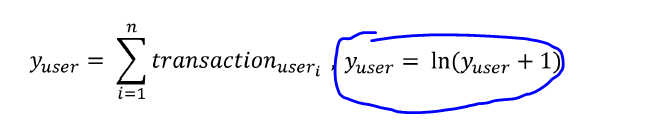

로그를 씌운 값을 예측하기 때문에 Y에 np.log1p 함수를 적용합니다.

In [71]:
Y = np.log1p(Y)

In [72]:
Y

0       17.449406
1       19.541283
2       18.035459
3       17.083177
4       20.168401
          ...    
1220    17.909522
1221    16.950135
1222    17.750078
1223    18.269625
1224    16.648136
Name: totals.transactionRevenue, Length: 1225, dtype: float64

로그 변환 후 타겟에 대한 분포

In [73]:
df.head()

,channelGrouping,date,socialEngagementType,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
752,Direct,9,Not Socially Engaged,1,4,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,Michigan,Detroit MI,Ann Arbor,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,11,11,NaN,1,(not set),(direct),(none),NaN,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
753,Organic Search,9,Not Socially Engaged,3,4,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,11,10,NaN,NaN,(not set),google,organic,(not provided),not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
799,Referral,9,Not Socially Engaged,7,23,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,13,11,NaN,NaN,(not set),mall.googleplex.com,referral,NaN,not available in demo dataset,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
802,Referral,9,Not Socially Engaged,6,4,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,not available in demo dataset,(not set),not available in demo dataset,no

In [75]:
df = pd.read_csv('df_final_1.csv')

In [76]:
df['totals.transactionRevenue']

0        37860000
1       306670000
2        68030000
3        26250000
4       574150000
          ...    
1220     59980000
1221     22980000
1222     51140000
1223     85980000
1224     16990000
Name: totals.transactionRevenue, Length: 1225, dtype: int64

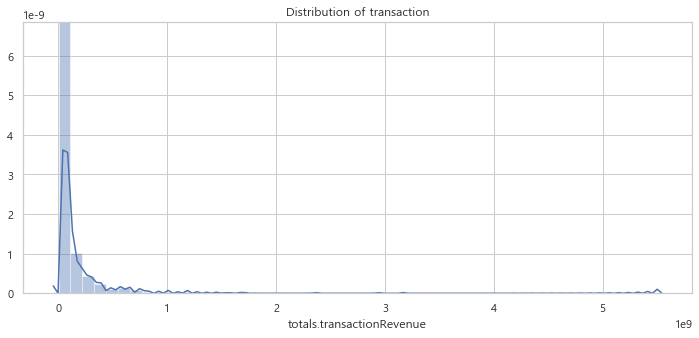

In [77]:
plt.figure(figsize=(12,5))
plt.title("Distribution of transaction")
ax = sns.distplot(df['totals.transactionRevenue'])

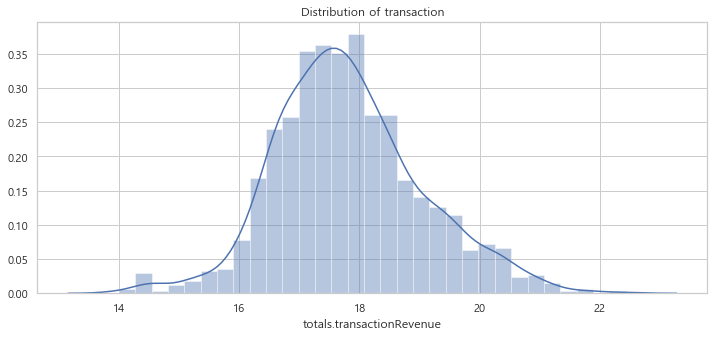

In [78]:
plt.figure(figsize=(12,5))
plt.title("Distribution of transaction")
ax = sns.distplot(Y)

모델링

In [79]:
seed = 42

RFR = RandomForestRegressor(random_state = seed)
SVR = SVR()

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [80]:
#cross_score = cross_val_score(RFR, X, Y, cv = 10, scoring='neg_mean_squared_error')
#rmse_score = np.sqrt(-cross_score) 
#rmse_mean = rmse_score.mean() 
#rmse_std = rmse_score.std()

In [81]:
def cross_score(model):
    cross_scoree = cross_val_score(model, X, Y, cv = 10, scoring='neg_mean_squared_error')
    rmse_score = np.sqrt(-cross_scoree) 
    rmse_mean = rmse_score.mean() 
    rmse_std = rmse_score.std()
    return print('rmse 평균 : ',  rmse_mean, 'rmse 편차 : ', rmse_std)

- 랜덤 포레스트

In [82]:
cross_score(RFR)

rmse 평균 :  1.1233582943766451 rmse 편차 :  0.051903593333365916


rmse 참고 : https://davinci-ai.tistory.com/18

- SVM

In [83]:
cross_score(SVR)

rmse 평균 :  1.1194442220911371 rmse 편차 :  0.06078966844791257


- 라잇 지비엠

In [84]:
from lightgbm.sklearn import LGBMRegressor

In [85]:
lgbmodel=LGBMRegressor(random_state= 42, learning_rate= 0.1, num_leaves= 30)

In [86]:
cross_score(lgbmodel)

rmse 평균 :  1.1649967150298735 rmse 편차 :  0.05813157138744272


xgboost

In [87]:
from xgboost import XGBRegressor

In [88]:
XGB=XGBRegressor(objective='reg:squarederror', random_state= 42)

In [89]:
cross_score(XGB)

rmse 평균 :  1.1117618811225651 rmse 편차 :  0.06476755114717832


모델 성능 정리

Random Forest
rmse 평균 : 1.09
rmse 편차 : 0.342

------------------------------------
SVM
rmse 평균 : 1.119
rmse 편차 : 0.039

------------------------------------
라잇 지비엠
rmse 평균 : 1.061
rmse 편차 : 0.032

------------------------------------
xgboost
rmse 평균 : 1.062
rmse 편차 : 0.035

------------------------------------

In [ ]:
d = 1

In [ ]:
dict = {'model': ['Random Forest', 'SVM', 'lightgbm', 'xgboost'], 'RMSE_Mean' : [1.09, 1.119, 1.061, 1.062],
       'RMSE_std':[0.342, 0.039, 0.032, 0.035]}

In [ ]:
model_score=pd.DataFrame(dict)

In [ ]:
model_score

In [ ]:
model_score=model_score.set_index('model')

In [ ]:
model_score.plot.barh(figsize = (10,7))

### feature importance

성능이 가장 우수한 light_gbm의 feature importance를 뽑아보겠습니다.

In [ ]:
features = X.columns.values

In [ ]:
features

In [ ]:
from sklearn.model_selection import cross_validate


In [ ]:
output = cross_validate(lgbmodel, X, Y, cv=10, scoring = 'neg_mean_squared_error', return_estimator =True)


In [ ]:
output

In [ ]:
X

In [ ]:
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = X.columns.values,
                                        columns=['importance']).sort_values('importance', ascending=False)
    FI=feature_importances

https://www.kaggle.com/codename007/home-credit-complete-eda-feature-importance#7.-Feature-Importance-using-Random-forest

In [ ]:
FI

In [ ]:
FI_10 = FI[:10]

feature importance 시각화

시각화 코드 참고(https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.cv.html)

In [ ]:
y = FI_10.index.values[::-1]
x = FI_10.importance.values[::-1]

In [ ]:
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()


In [ ]:
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 500,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ),
    margin=dict(
    l=300,
),
)

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

피쳐 중요도 상위 10개 피쳐를 뽑아 시각화 했습니다.

---

In [ ]:
>>> import numpy as np
>>> from sklearn.model_selection import KFold
>>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
>>> y = np.array([1, 2, 3, 4])
>>> kf = KFold(n_splits=2)
>>> kf.get_n_splits(X)
2
>>> print(kf)
KFold(n_splits=2, random_state=None, shuffle=False)
>>> for train_index, test_index in kf.split(X):
...     print("TRAIN:", train_index, "TEST:", test_index)
...     X_train, X_test = X[train_index], X[test_index]
...     y_train, y_test = y[train_index], y[test_index]
TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]
        
>>> from sklearn.inspection import permutation_importance
>>> r = permutation_importance(model, X_val, y_val,
...                            n_repeats=30,
...                            random_state=0)
...
>>> for i in r.importances_mean.argsort()[::-1]:
...     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
...         print(f"{diabetes.feature_names[i]:<8}"
...               f"{r.importances_mean[i]:.3f}"
...               f" +/- {r.importances_std[i]:.3f}")
...
s5      0.204 +/- 0.050
bmi     0.176 +/- 0.048
bp      0.088 +/- 0.033
sex     0.056 +/- 0.023

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
x

In [ ]:
r = permutation_importance(lgbmodel, X, Y,
                            n_repeats=30,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{diabetes.feature_names[i]:<8}"
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")